### Abstract¶
#### This notebook pertains to deep learning based anomaly detection and prediction for threat identication and foreasting.

In [46]:
# !pip3 install tensorflow

In [3]:
import numpy as np
import pandas as pd
import scipy as scp

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

import matplotlib.pyplot as pp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import csv
import os
import glob

## Setting the seed for consistent results across runs
np.random.seed(1000)
tf.random.set_seed(1000)

In [4]:
## Load and Cleanup data
def load_and_process_data(data_path, fl_type):
    Xdata_train = []
    Xdata_test  = []
    Xdata_test_labels = []

    ## Load and clean data
    os.chdir(data_path)
    trgt_str = '*' + fl_type + '*.csv'
    for file in glob.glob(trgt_str):
        with open(file, newline='') as csvfile:
            df = pd.read_csv(csvfile)
            vector_not_null = df['value'].notnull()
            df_not_null = df[vector_not_null]
            df_clean = df_not_null[['timestamp', 'value', 'anomaly']]
            df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
            df_clean_train, df_clean_test = train_test_split(df_clean, test_size=0.2, shuffle=False)
            df_clean_train.to_csv('training_data_cleaned.csv', index=None, header=True, encoding='utf-8-sig')
            df_clean_test.to_csv('testing_data_cleaned.csv', index=None, header=True, encoding='utf-8-sig')
        with open('training_data_cleaned.csv', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            first_row = next(reader)
            time_index = 0
            time_index_seq = []
            for row in reader:
                time_index = time_index + 1
                if row['anomaly'] == 'False':
                    time_index_seq.append(time_index)
                    Xdata_train.append(np.float64(row['value']))
                else:
                    f = scp.interpolate.interp1d(time_index_seq, Xdata_train, fill_value='extrapolate')
                    time_index_seq.append(time_index)
                    Xdata_train.append(f(time_index))
        with open('testing_data_cleaned.csv', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            first_row = next(reader)
            for row in reader:
                Xdata_test.append(np.float64(row['value']))
                Xdata_test_labels.append(row['anomaly'])

    return Xdata_train, Xdata_test, Xdata_test_labels

In [42]:
## Visualize data
def data_viz(dt, true_lbls, pred_lbls):
    true_anmly_idxs = [i for i, val in enumerate(true_lbls) if val]
    true_anmly_dt = [dt[i] for i in true_anmly_idxs]

    pred_anmly_idxs = [i for i, val in enumerate(pred_lbls) if val]
    pred_anmly_dt = [dt[i] for i in pred_anmly_idxs]

    fg = pp.figure()
    fig = fg.add_subplot(111)
    figget = pp.gcf()
    figget.set_size_inches(18, 7)

    ## Hide the right and top spines
    fig.spines['right'].set_visible(False)
    fig.spines['top'].set_visible(False)

    for axis in ['bottom', 'left']:
        fig.spines[axis].set_linewidth(3.0)

    ## Only show ticks on the left and bottom spines
    fig.yaxis.set_ticks_position('left')
    fig.xaxis.set_ticks_position('bottom')

    ## Change the fontsize of ticks label
    fig.tick_params(axis='both', which='major', labelsize=16)
    fig.tick_params(axis='both', which='minor', labelsize=16)

    fig.plot(dt, 'o--', linewidth=3.0, markersize=5, zorder=1)
    fig.scatter(true_anmly_idxs, true_anmly_dt, color="red", s=50, zorder=2)
    fig.scatter(pred_anmly_idxs, pred_anmly_dt, color="green", s=50, zorder=2)

    fig.legend(["Data", "True Anomaly", "Predicted Anomaly"])
    fig.set_title("Anomalies over Time", fontsize=24)
    pp.xlabel('Time Instances', fontsize=16)
    pp.ylabel('Values', fontsize=16)
    return

In [19]:
## Create LSTM sequences - Convert input data into 3-D array combining number of steps for prediction.
## The shape of the array should be [samples, steps, features], as required for LSTM network.
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    
    return np.array(Xs), np.array(ys)

In [44]:
if __name__ == '__main__':

    ## Change this to the data file you want to model and your local data path
    file_type = 'px_pool_stats_pool_writethroughput'
    data_path = 'data_20201111/'

    training_data, testing_data, testing_labels = load_and_process_data(data_path, file_type)

    ## Normalize the data (For LSTM convergence)
    scaler = StandardScaler()
    scaler = scaler.fit(np.array(training_data).reshape(-1,1))

    training_data = scaler.transform(np.array(training_data).reshape(-1,1))
    testing_data = scaler.transform(np.array(testing_data).reshape(-1,1))

    ## Create LSTM formatted sequences
    sequence_length = 60
    X_train, y_train = create_sequences(training_data, training_data, sequence_length)
    X_test, y_test = create_sequences(testing_data, testing_data, sequence_length)

    print(f'Training shape: {X_train.shape}')
    print(f'Testing shape: {X_test.shape}')

    ## Create the Keras model (The hyper-parameters need to be tuned)
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=0.2))
    model.add(RepeatVector(X_train.shape[1]))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(TimeDistributed(Dense(X_train.shape[2])))
    model.compile(optimizer='adam', loss='mae')
    model.summary()

    # Train the model (Play with the parameters here)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')],
                        shuffle=False)

    ## Determine threshold for anomaly detection based on max. error in the training data
    X_train_pred = model.predict(X_train, verbose=0)
    train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

    threshold = np.max(train_mae_loss)
    print(f'Reconstruction error threshold: {threshold}')

    ## Determine anomalies in the testing data
    X_test_pred = model.predict(X_test, verbose=0)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1).tolist()

    ## Compare True and Predicted labels and Plot Them
    data_to_compare = testing_data[sequence_length:]
    true_labels = []
    for tmp in testing_labels[sequence_length:]:
        if tmp == 'False':
            true_labels.append(0)
        else:
            true_labels.append(1)
    predicted_labels = test_mae_loss > threshold

    print(f'Percentage Accuracy: {100*accuracy_score(true_labels, predicted_labels, normalize=True)}')


/var/folders/vm/zrwt797n3fb0txbqj90_8yc00000gp/T/ipykernel_87120/933656487.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])


Training shape: (25213, 60, 1)
Testing shape: (6258, 60, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 60, 128)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 60, 128)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 60, 1)            129  

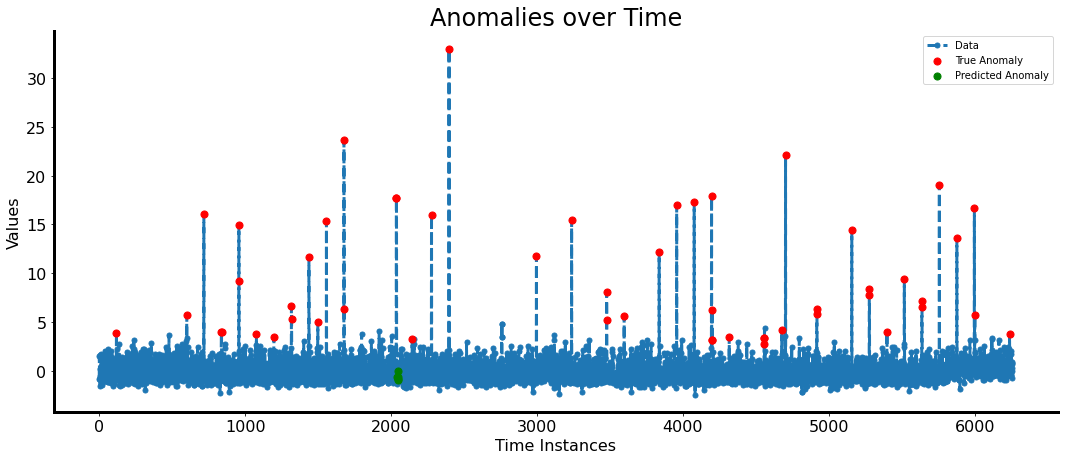

In [45]:
data_viz(data_to_compare, true_labels, predicted_labels)

pp.show()